# MESA Ecospatial Tutorials (hepatocellular carcinoma, CosMx)

In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.figure import figaspect

import os
os.sys.path.append('../../../')
from mesa import ecospatial as eco

/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [2]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'  # To keep text as editable text in SVGs

## Helper functions

In [3]:
import time
from typing import Union,List
def overlap_check(new_patch, existing_patches, max_overlap_ratio):
    """
    This function checks if the new patch overlaps with any of the existing patches.
    
    Parameters:
    new_patch: tuple
        The coordinates of the new patch to be checked for overlaps.
    existing_patches: list
        A list of existing patches to check for overlaps.
    max_overlap_ratio: float
        The maximum allowable overlap ratio for a new patch.
    
    Returns:
    bool
        Returns True if the new patch doesn't overlap with any existing patch beyond the allowable overlap ratio.
        Otherwise, returns False.
    """
    
    patch_area = (new_patch[2] - new_patch[0]) * (new_patch[3] - new_patch[1])
    max_overlap = max_overlap_ratio * patch_area
    for patch in existing_patches:
        dx = min(new_patch[2], patch[2]) - max(new_patch[0], patch[0])
        dy = min(new_patch[3], patch[3]) - max(new_patch[1], patch[1])
        if (dx>=0) and (dy>=0) and (dx*dy > max_overlap):
            return False
    return True

def contains_points(patch, spatial_values, min_points):
    """
    This function checks if a patch contains a certain number of spatial values (points).
    
    Parameters:
    patch: tuple
        The coordinates of the patch to be checked.
    spatial_values: list
        A list of spatial values (cells' coordinates) to check if they are within the patch.
    min_points: int
        The minimum number of points that the patch should contain.
        
    Returns:
    bool
        Returns True if the patch contains at least 'min_points' number of spatial values（cells' coordinates）. Otherwise, returns False.
    """
    
    # Count the points within the patch
    points_in_patch = sum((patch[0] <= point[0] <= patch[2]) and (patch[1] <= point[1] <= patch[3]) for point in spatial_values)
    
    # Check if the number of points in the patch is at least min_points
    return points_in_patch >= min_points
def subsampling_randomly(spatial_data: Union[ad.AnnData, pd.DataFrame], 
                         library_key:str, 
                         library_id:str, 
                         sample_size:Union[int,float], 
                         sample_number:int,
                         spatial_key:Union[str,List[str]], 
                         max_overlap=0.0, 
                         random_seed=None, 
                         min_points=2):
    
    rng = np.random.default_rng(random_seed)

    if isinstance(spatial_data, ad.AnnData):
        spatial_data_filtered = spatial_data[spatial_data.obs[library_key] == library_id]
    elif isinstance(spatial_data, pd.DataFrame):
        spatial_data_filtered = spatial_data[spatial_data[library_key] == library_id]
    else:
        raise ValueError("spatial_data should be either an AnnData object or a pandas DataFrame")
    
    if isinstance(spatial_data, ad.AnnData):
        spatial_values = spatial_data_filtered.obsm[spatial_key]
    elif isinstance(spatial_data, pd.DataFrame):
        spatial_values = spatial_data_filtered[spatial_key].values
    else:
        raise ValueError("spatial_data should be either an AnnData object or a pandas DataFrame")

    width = spatial_values.max(axis=0)[0] - spatial_values.min(axis=0)[0]
    height = spatial_values.max(axis=0)[1] - spatial_values.min(axis=0)[1]

    patch_width = sample_size[0]
    patch_height = sample_size[1] if sample_size[1] else sample_size[0]

    num_patches = sample_number

    patches = []
    used_coordinates = set()
    
    for _ in range(num_patches):
        start_time = time.time()
        while True:
            if time.time() - start_time > 5:  # seconds
                print(f"Warning: Could not generate a new patch within 5 seconds. Return {len(patches)} out of {num_patches} patches")
                return patches
            
            x0 = rng.uniform(spatial_values.min(axis=0)[0], spatial_values.max(axis=0)[0] - patch_width)
            y0 = rng.uniform(spatial_values.min(axis=0)[1], spatial_values.max(axis=0)[1] - patch_height)
            x1 = x0 + patch_width
            y1 = y0 + patch_height
            new_patch = (x0, y0, x1, y1)
            if ((x0, y0) not in used_coordinates and 
                overlap_check(new_patch, patches, max_overlap) and 
                contains_points(new_patch, spatial_values, min_points)  ):
                used_coordinates.add((x0, y0))
                patches.append(new_patch)
                break

    return patches

## Read Data

In [4]:
liver_df = pd.read_csv('/Users/Emrys/Dropbox/spatial_augmentation/data/cosMx_liver/data/cosMx_liver_meta.csv')

In [5]:
liver_df = liver_df[['cell_ID', 'Run_Tissue_name', 'x_slide_mm', 'y_slide_mm', 'fov', 'nCell', 'cellType', 'niche']].copy()
liver_df['x_slide_um'] = (liver_df['x_slide_mm']*1000.0).round(0)
liver_df['y_slide_um'] = (liver_df['y_slide_mm']*1000.0).round(0)
liver_df.head()

,cell_ID,Run_Tissue_name,x_slide_mm,y_slide_mm,fov,nCell,cellType,niche,x_slide_um,y_slide_um
0,c_1_100_10,NormalLiver,9.03144,9.73500,100,1265,Hep.3,Zone_3a,9031.0,9735.0
1,c_1_100_1078,NormalLiver,8.77440,9.25824,100,1265,Hep.4,Zone_2a,8774.0,9258.0
2,c_1_100_1135,NormalLiver,8.87928,9.23412,100,1265,Inflammatory.macrophages,Zone_2a,8879.0,9234.0
3,c_1_100_267,NormalLiver,9.12132,9.61104,100,1265,Hep.5,Zone_2a,9121.0,9611.0
4,c_1_100_732,NormalLiver,9.08436,9.40548,100,1265,Central.venous.LSECs,Zone_2a,9084.0,9405.0


In [6]:
liver_df.loc[:, 'sample'] = '-1'  # Initialize the 'patches' column with -1 
patches_coord_dict = {}
for tissue_type in pd.unique(liver_df['Run_Tissue_name']):
    print(f"Processing {tissue_type}", flush=True)
    # patches_coord = subsampling(liver_df,
    #                             'Run_Tissue_name',
    #                             tissue_type,
    #                             num_squares=[11.0,8.0], 
    #                             spatial_key=['x_slide_um', 'y_slide_um'])

    patches_coord = subsampling_randomly(spatial_data=liver_df, 
                                         library_key='Run_Tissue_name', 
                                         library_id=tissue_type, 
                                         sample_size=[1600,1600],
                                         sample_number=10,
                                         spatial_key=['x_slide_um', 'y_slide_um'], 
                                         max_overlap=0.0, 
                                         random_seed=42, 
                                         min_points=12000)    
    
    patches_coord_dict[tissue_type] = patches_coord
    print(f"Total number of patches: {len(patches_coord)}",flush=True)
    print(patches_coord)
    # Iterate over patches
    for i, patch in enumerate(patches_coord):
        x0, y0, x1, y1 = patch
        
        # Define the number of decimal places for rounding
        decimal_places = 5
        
        # When assigning patch coordinates
        x0 = round(x0, decimal_places)
        y0 = round(y0, decimal_places)
        x1 = round(x1, decimal_places)
        y1 =round(y1, decimal_places)
    
        # Update the 'patches' column for cells within the current patch
        if tissue_type == 'NormalLiver':
            sample_name = 'N'+str(i)
        else:
            sample_name = 'C'+str(i)
            
        liver_df.loc[
            (liver_df['Run_Tissue_name'] == tissue_type) &
            (liver_df['x_slide_um'] >= x0) & 
            (liver_df['x_slide_um'] <= x1) & 
            (liver_df['y_slide_um'] >= y0) & 
            (liver_df['y_slide_um'] <= y1), 
            'sample'
        ] = sample_name
        
liver_df.drop(liver_df[ (liver_df['sample'] == '-1')].index, inplace=True)

Processing NormalLiver
Total number of patches: 10
[(1886.6148806917008, 10025.667690297836, 3486.614880691701, 11625.667690297836), (7967.310663046048, 8786.71629929017, 9567.310663046048, 10386.71629929017), (2196.0119891029517, 6592.722490085427, 3796.0119891029517, 8192.722490085427), (4408.565586928444, 9706.33596711446, 6008.565586928444, 11306.33596711446), (5070.607250708777, 5134.232285585302, 6670.607250708777, 6734.232285585302), (2302.5292319298533, 4397.568560631123, 3902.5292319298533, 5997.568560631123), (7121.82980264373, 6728.084803351514, 8721.82980264373, 8328.084803351514), (2416.6294404359564, 8200.149971508083, 4016.6294404359564, 9800.149971508083), (9767.184347122256, 6801.335263858796, 11367.184347122256, 8401.335263858797), (4050.9145487720484, 7052.114822553971, 5650.914548772049, 8652.114822553971)]
Processing CancerousLiver
Total number of patches: 10
[(8733.940845498759, 6956.522134005294, 10333.940845498759, 8556.522134005294), (959.7836280173957, 9924.93

## Perform Ecospatial Analysis on one sample

1.953 per cent patches are empty


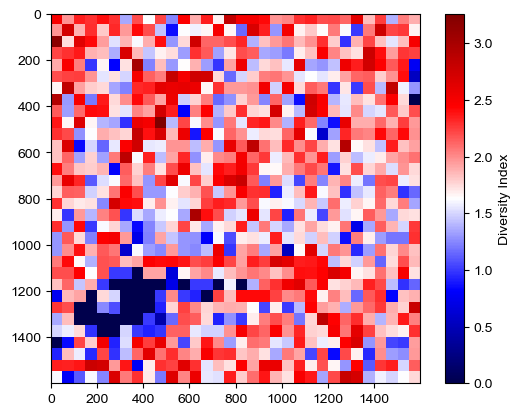

In [43]:
test_sample = 'N7'
patches_coordinates = eco.generate_patches(liver_df,
                                           'sample',
                                           test_sample,
                                           scaling_factor=32.,
                                           spatial_key=['x_slide_um', 'y_slide_um'])

patch_indices, patches_comp = eco.calculate_diversity_index(spatial_data=liver_df, 
                                                            library_key='sample', 
                                                            library_id=test_sample, 
                                                            spatial_key=['x_slide_um', 'y_slide_um'], 
                                                            patches=patches_coordinates, 
                                                            cluster_key='cellType', 
                                                            metric='Shannon Diversity', return_comp=True)


# Visualize the heterogeneity indices
grid, heatmap_fig = eco.diversity_heatmap(spatial_data=liver_df,
                                          library_key='sample', 
                                          library_id=test_sample,
                                          spatial_key=['x_slide_um', 'y_slide_um'],
                                          patches=patches_coordinates, 
                                          heterogeneity_indices=patch_indices,
                                          tissue_only=True,
                                          plot=True,
                                          return_fig=True)

In [44]:
print(eco.global_spatial_stats(grid, tissue_only=True))

Global spatial stats restricted to tissue region with w of shape (1004, 1004)
(0.09882209548413516, 0.001)


In [45]:
hotspots, coldspots = eco.local_spatial_stats(grid,tissue_only=True,p_value=0.01,plot_weights=False)
print(sum(hotspots.flatten()), flush=True)
print(sum(coldspots.flatten()), flush=True)

(1004,)
Local spatial stats restricted to tissue region with w of shape(1004, 1004)
Using MoranI
26
21


In [41]:
Hot=True
if Hot:
    filtered_patches_coordinates = [patch for patch, is_hotspot in zip(patches_coordinates, hotspots.flatten()) if is_hotspot]
    filtered_patches_comp = [patch for patch, is_hotspot in zip(patches_comp, hotspots.flatten()) if is_hotspot]
else:
    filtered_patches_coordinates = [patch for patch, is_coldspot in zip(patches_coordinates, coldspots.flatten()) if is_coldspot]
    filtered_patches_comp = [patch for patch, is_coldspot in zip(patches_comp, coldspots.flatten()) if is_coldspot]

In [42]:
pd.concat(filtered_patches_comp, axis=1).sum(axis=1)

cellType
tumor_2                          42.0
tumor_1                         290.0
Periportal.LSECs                 31.0
Stellate.cells                   91.0
CD3+.alpha.beta.T.cells         184.0
Inflammatory.macrophages        206.0
Non.inflammatory.macrophages     53.0
NK.like.cells                     6.0
Central.venous.LSECs             14.0
Mature.B.cells                   39.0
gamma.delta.T.cells.1             3.0
Portal.endothelial.cells          2.0
Cholangiocytes                    1.0
dtype: float64

## Perform Ecospatial Analysis on all samples

In [7]:
library_ids = liver_df['sample'].unique().tolist()
library_ids = [
    l for l in library_ids if 'N' in l or 'C' in l
]

### Calculate Global Cell Frequency & Cell Co-Occurrence

In [8]:
global_cellfreq_df, global_co_occurrence_df = eco.spot_cellfreq(spatial_data=liver_df, 
                                                                scale=32.0, 
                                                                library_key='sample',
                                                                library_id=library_ids, 
                                                                spatial_key=['x_slide_um', 'y_slide_um'],
                                                                cluster_key='cellType',
                                                                spots='global',
                                                                top=None,
                                                                selected_comb=None,
                                                                restricted=False,
                                                                metric='Shannon Diversity')

Processing region: N1 at scale 32.0
1.465 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: N7 at scale 32.0
1.953 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: N9 at scale 32.0
0.000 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: N6 at scale 32.0
0.195 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: N8 at scale 32.0
0.195 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: N2 at scale 32.0
0.000 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: N4 at scale 32.0
0.000 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: N5 at scale 32.0
0.098 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: N0 at scale 32.0
0.684 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: N3 at scale 32.0
0

In [9]:
global_cellfreq_df['Condition'] = ' '
global_cellfreq_df.loc[global_cellfreq_df.index.str.contains('N'), 'Condition'] = 'Healthy'
global_cellfreq_df.loc[global_cellfreq_df.index.str.contains('C'), 'Condition'] = 'HCC'

global_co_occurrence_subcols = global_co_occurrence_df.loc[:,global_co_occurrence_df.mean()>0.05].columns.tolist()
global_co_occurrence_df['Condition'] = ' '
global_co_occurrence_df['sample'] = global_co_occurrence_df.index
global_co_occurrence_df.loc[global_co_occurrence_df.index.str.contains('N'), 'Condition'] = 'Healthy'
global_co_occurrence_df.loc[global_co_occurrence_df.index.str.contains('C'), 'Condition'] = 'HCC'
global_co_occurrence_subcols.extend([('Condition',''),('sample','')])

In [10]:
# Melt the dataframe for easier plotting and statistical analysis
global_cellfreq_df_melt = global_cellfreq_df.reset_index().melt(id_vars=['sample', 'Condition'])
global_cellfreq_df_melt.columns = ['sample', 'group', 'cellType', 'Frequency']

global_cellfreq_df_melt

,sample,group,cellType,Frequency
0,C0,HCC,Antibody.secreting.B.cells,0.001204
1,C1,HCC,Antibody.secreting.B.cells,0.000233
2,C2,HCC,Antibody.secreting.B.cells,0.003202
3,C3,HCC,Antibody.secreting.B.cells,0.004519
4,C4,HCC,Antibody.secreting.B.cells,0.001152
...,...,...,...,...
435,N5,Healthy,tumor_2,0.000000
436,N6,Healthy,tumor_2,0.000000
437,N7,Healthy,tumor_2,0.000000
438,N8,Healthy,tumor_2,0.000000


Antibody.secreting.B.cells has p value of 0.7253105069107637
CD3+.alpha.beta.T.cells has p value of 0.6688961489467853
Central.venous.LSECs has p value of 1.3650725054199515e-09
Cholangiocytes has p value of 5.184474315672871e-05
Erthyroid.cells has p value of 1.962577398118726e-08
Hep has p value of 0.3128233608731258
Hep.1 has p value of 1.4655635733085782e-05
Hep.3 has p value of 2.517630979080062e-10
Hep.4 has p value of 5.087963668099555e-10
Hep.5 has p value of 3.9066463036613865e-11
Hep.6 has p value of 2.0930984873598823e-06
Inflammatory.macrophages has p value of 0.14611237799276483
Mature.B.cells has p value of 0.5028132228052369
NK.like.cells has p value of 3.7138952557959555e-07
Non.inflammatory.macrophages has p value of 0.3171705903870426
NotDet has p value of 0.9868237859133563
Periportal.LSECs has p value of 0.3792861739107447
Portal.endothelial.cells has p value of 0.042454116173829735
Stellate.cells has p value of 0.0038202017195151047
gamma.delta.T.cells.1 has p valu

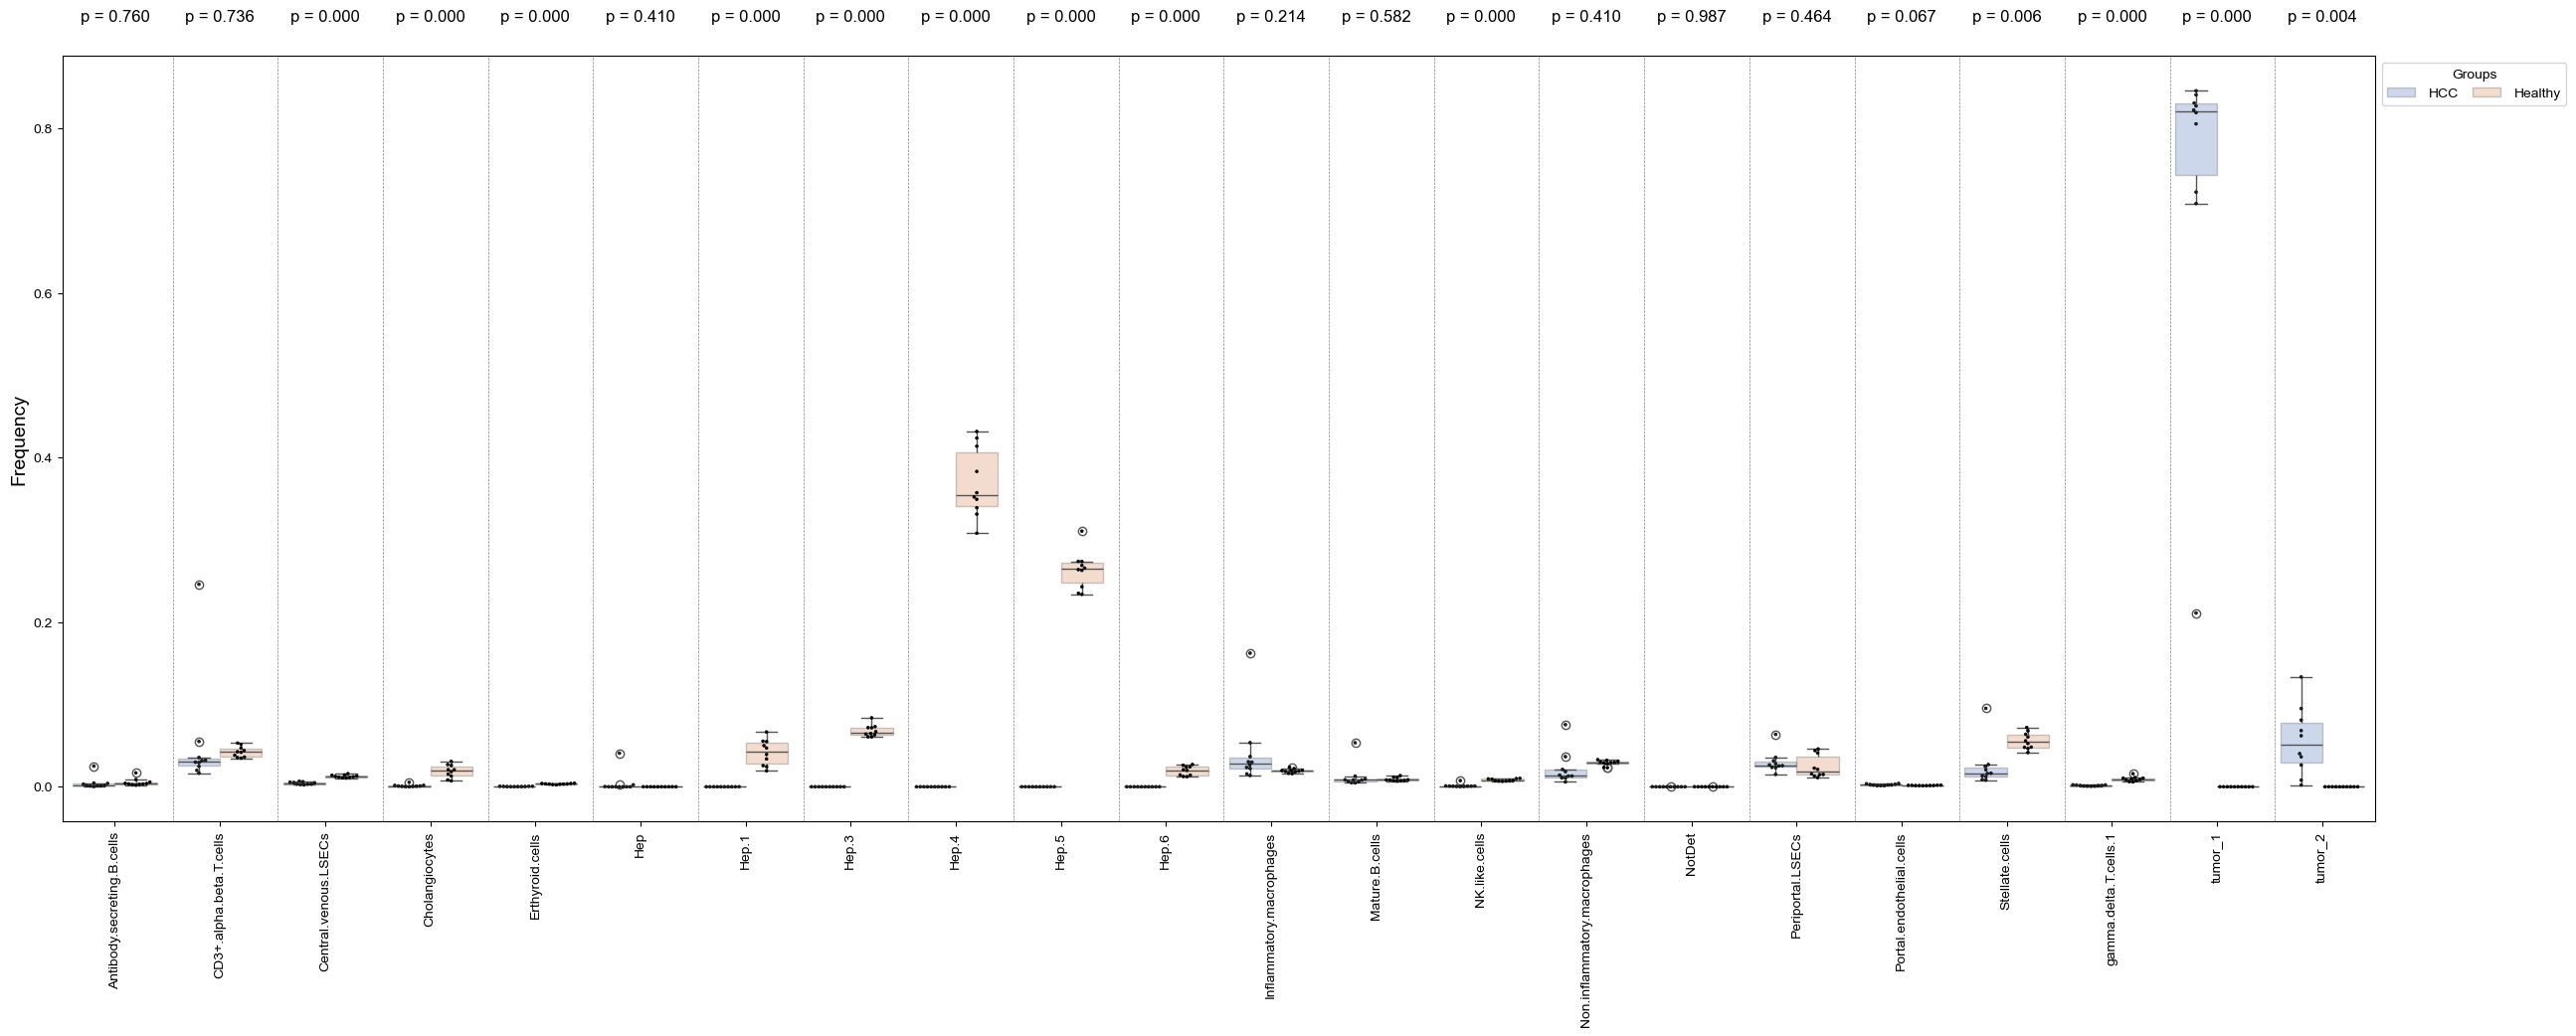

In [11]:
# Perform t-tests
selected_cell_types = sorted(liver_df['cellType'].unique())
selected_p_values = []
for ct in selected_cell_types:
    group1 = global_cellfreq_df_melt[(global_cellfreq_df_melt['cellType'] == ct) & (global_cellfreq_df_melt['group'] == 'Healthy')]['Frequency']
    group2 = global_cellfreq_df_melt[(global_cellfreq_df_melt['cellType'] == ct) & (global_cellfreq_df_melt['group'] == 'HCC')]['Frequency']
    t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
    print(f"{ct} has p value of {p_value}")
    selected_p_values.append(p_value)

pvals_corrected = stats.false_discovery_control(selected_p_values, method='bh')
print('-'*42)
print(f"p-values after correction:")

# Plot
fig, ax = plt.subplots(figsize=(30,10))
sns.boxplot(data=global_cellfreq_df_melt, x='cellType', y='Frequency', hue='group', palette='muted', boxprops=dict(alpha=.3), ax=ax, dodge=True, order=selected_cell_types)
sns.swarmplot(data=global_cellfreq_df_melt, x='cellType', y='Frequency', hue='group', palette='dark:black', size=2.0, dodge=True, order=selected_cell_types, ax=ax, edgecolor='auto', linewidth=0.5)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="Groups", handletextpad=1, columnspacing=1, bbox_to_anchor=(1, 1), ncol=3, frameon=True)
plt.xticks(rotation=90)

p_vals_corrected_dict = {}
yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
for i, ct in enumerate(selected_cell_types):
    ax.text(i, yrange, f"p = {pvals_corrected[i]:.3f}", ha='center', fontsize=12, rotation=0)
    print(f"{ct} has p value = {pvals_corrected[i]:.3f}", flush=True)
    p_vals_corrected_dict[ct] = pvals_corrected[i]
    
for i in range(len(selected_cell_types) - 1):
    ax.axvline(i + 0.55, color='grey', linestyle='--', linewidth=0.5)
    
ax.set_ylabel("Frequency", fontsize=14)
ax.set_xlabel('') 
plt.show()

### Calculate Cell Frequency and Cell Co-Occurrence in hot/coldspots

In [22]:
spot_cellfreq_df, spot_co_occurrence_df = eco.spot_cellfreq(spatial_data=liver_df, 
                                                            scale=32.0, 
                                                            library_key='sample',
                                                            library_id=library_ids, 
                                                            spatial_key=['x_slide_um', 'y_slide_um'],
                                                            cluster_key='cellType',
                                                            spots='hot',
                                                            top=None,
                                                            selected_comb=None,
                                                            restricted=True,
                                                            metric='Shannon Diversity')

Processing region: N1 at scale 32.0
1.465 per cent patches are empty
(1009,)
Local spatial stats restricted to tissue region with w of shape(1009, 1009)
Using MoranI
Region N1 contains 6 diversity hotspots
Processing region: N7 at scale 32.0
1.953 per cent patches are empty
(1004,)
Local spatial stats restricted to tissue region with w of shape(1004, 1004)
Using MoranI
Region N7 contains 26 diversity hotspots
Processing region: N9 at scale 32.0
0.000 per cent patches are empty
(1024,)
Local spatial stats restricted to tissue region with w of shape(1024, 1024)
Using MoranI
Region N9 contains 13 diversity hotspots
Processing region: N6 at scale 32.0
0.195 per cent patches are empty
(1022,)
Local spatial stats restricted to tissue region with w of shape(1022, 1022)
Using MoranI
Region N6 contains 13 diversity hotspots
Processing region: N8 at scale 32.0
0.195 per cent patches are empty
(1022,)
Local spatial stats restricted to tissue region with w of shape(1022, 1022)
Using MoranI
Region 

/Users/Emrys/MESA/docs/notebooks/tutorials/../../../mesa/ecospatial/_ecospatial.py:111: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 46.
  w_new = weights.W(neighbors=new_neighbors, weights=new_weights)


6.348 per cent patches are empty
(959,)
Local spatial stats restricted to tissue region with w of shape(959, 959)
Using MoranI
Region C8 contains 25 diversity hotspots


/Users/Emrys/MESA/docs/notebooks/tutorials/../../../mesa/ecospatial/_ecospatial.py:111: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 31, 35.
  w_new = weights.W(neighbors=new_neighbors, weights=new_weights)


In [24]:
spot_cellfreq_df['Condition'] = ' '
if 'NotDet' in spot_cellfreq_df.columns:
    spot_cellfreq_df = spot_cellfreq_df.drop(columns='NotDet')
spot_cellfreq_df.loc[spot_cellfreq_df.index.str.contains('N'), 'Condition'] = 'Healthy'
spot_cellfreq_df.loc[spot_cellfreq_df.index.str.contains('C'), 'Condition'] = 'HCC'

spot_co_occurrence_subcols = spot_co_occurrence_df.loc[:,spot_co_occurrence_df.mean()>0.05].columns.tolist()
spot_co_occurrence_df['Condition'] = ' '
spot_co_occurrence_df['sample'] = spot_co_occurrence_df.index
spot_co_occurrence_df.loc[spot_co_occurrence_df.index.str.contains('N'), 'Condition'] = 'Healthy'
spot_co_occurrence_df.loc[spot_co_occurrence_df.index.str.contains('C'), 'Condition'] = 'HCC'
spot_co_occurrence_subcols.extend([('Condition',''),('sample','')])

In [25]:
spot_cellfreq_df['sample'] = spot_cellfreq_df.index

# Melt the DataFrame
spot_cellfreq_df_melt = spot_cellfreq_df.melt(id_vars=['sample', 'Condition'], var_name='CellType', value_name='Frequency')

In [26]:
spot_cellfreq_df_melt

,sample,Condition,CellType,Frequency
0,N1,Healthy,Antibody.secreting.B.cells,0.000000
1,N7,Healthy,Antibody.secreting.B.cells,0.042184
2,N9,Healthy,Antibody.secreting.B.cells,0.028409
3,N6,Healthy,Antibody.secreting.B.cells,0.040201
4,N8,Healthy,Antibody.secreting.B.cells,0.012658
...,...,...,...,...
415,C7,HCC,tumor_2,0.043659
416,C9,HCC,tumor_2,0.091346
417,C2,HCC,tumor_2,0.207407
418,C3,HCC,tumor_2,0.125506


p-value before correction:
Antibody.secreting.B.cells has p value = 0.6141
CD3+.alpha.beta.T.cells has p value = 0.0936
Central.venous.LSECs has p value = 0.0433
Cholangiocytes has p value = 0.0485
Erthyroid.cells has p value = 0.0451
Hep has p value = 0.2253
Hep.1 has p value = 0.0046
Hep.3 has p value = 0.0001
Hep.4 has p value = 0.0001
Hep.5 has p value = 0.0002
Hep.6 has p value = 0.0055
Inflammatory.macrophages has p value = 0.0018
Mature.B.cells has p value = 0.0876
NK.like.cells has p value = 0.0342
Non.inflammatory.macrophages has p value = 0.2004
Periportal.LSECs has p value = 0.5968
Portal.endothelial.cells has p value = 0.5409
Stellate.cells has p value = 0.3656
gamma.delta.T.cells.1 has p value = 0.4125
tumor_1 has p value = 0.0000
tumor_2 has p value = 0.0020
------------------------------------------
p-values after correction: 
Antibody.secreting.B.cells in hot spots has p value = 0.614
CD3+.alpha.beta.T.cells in hot spots has p value = 0.140
Central.venous.LSECs in hot s

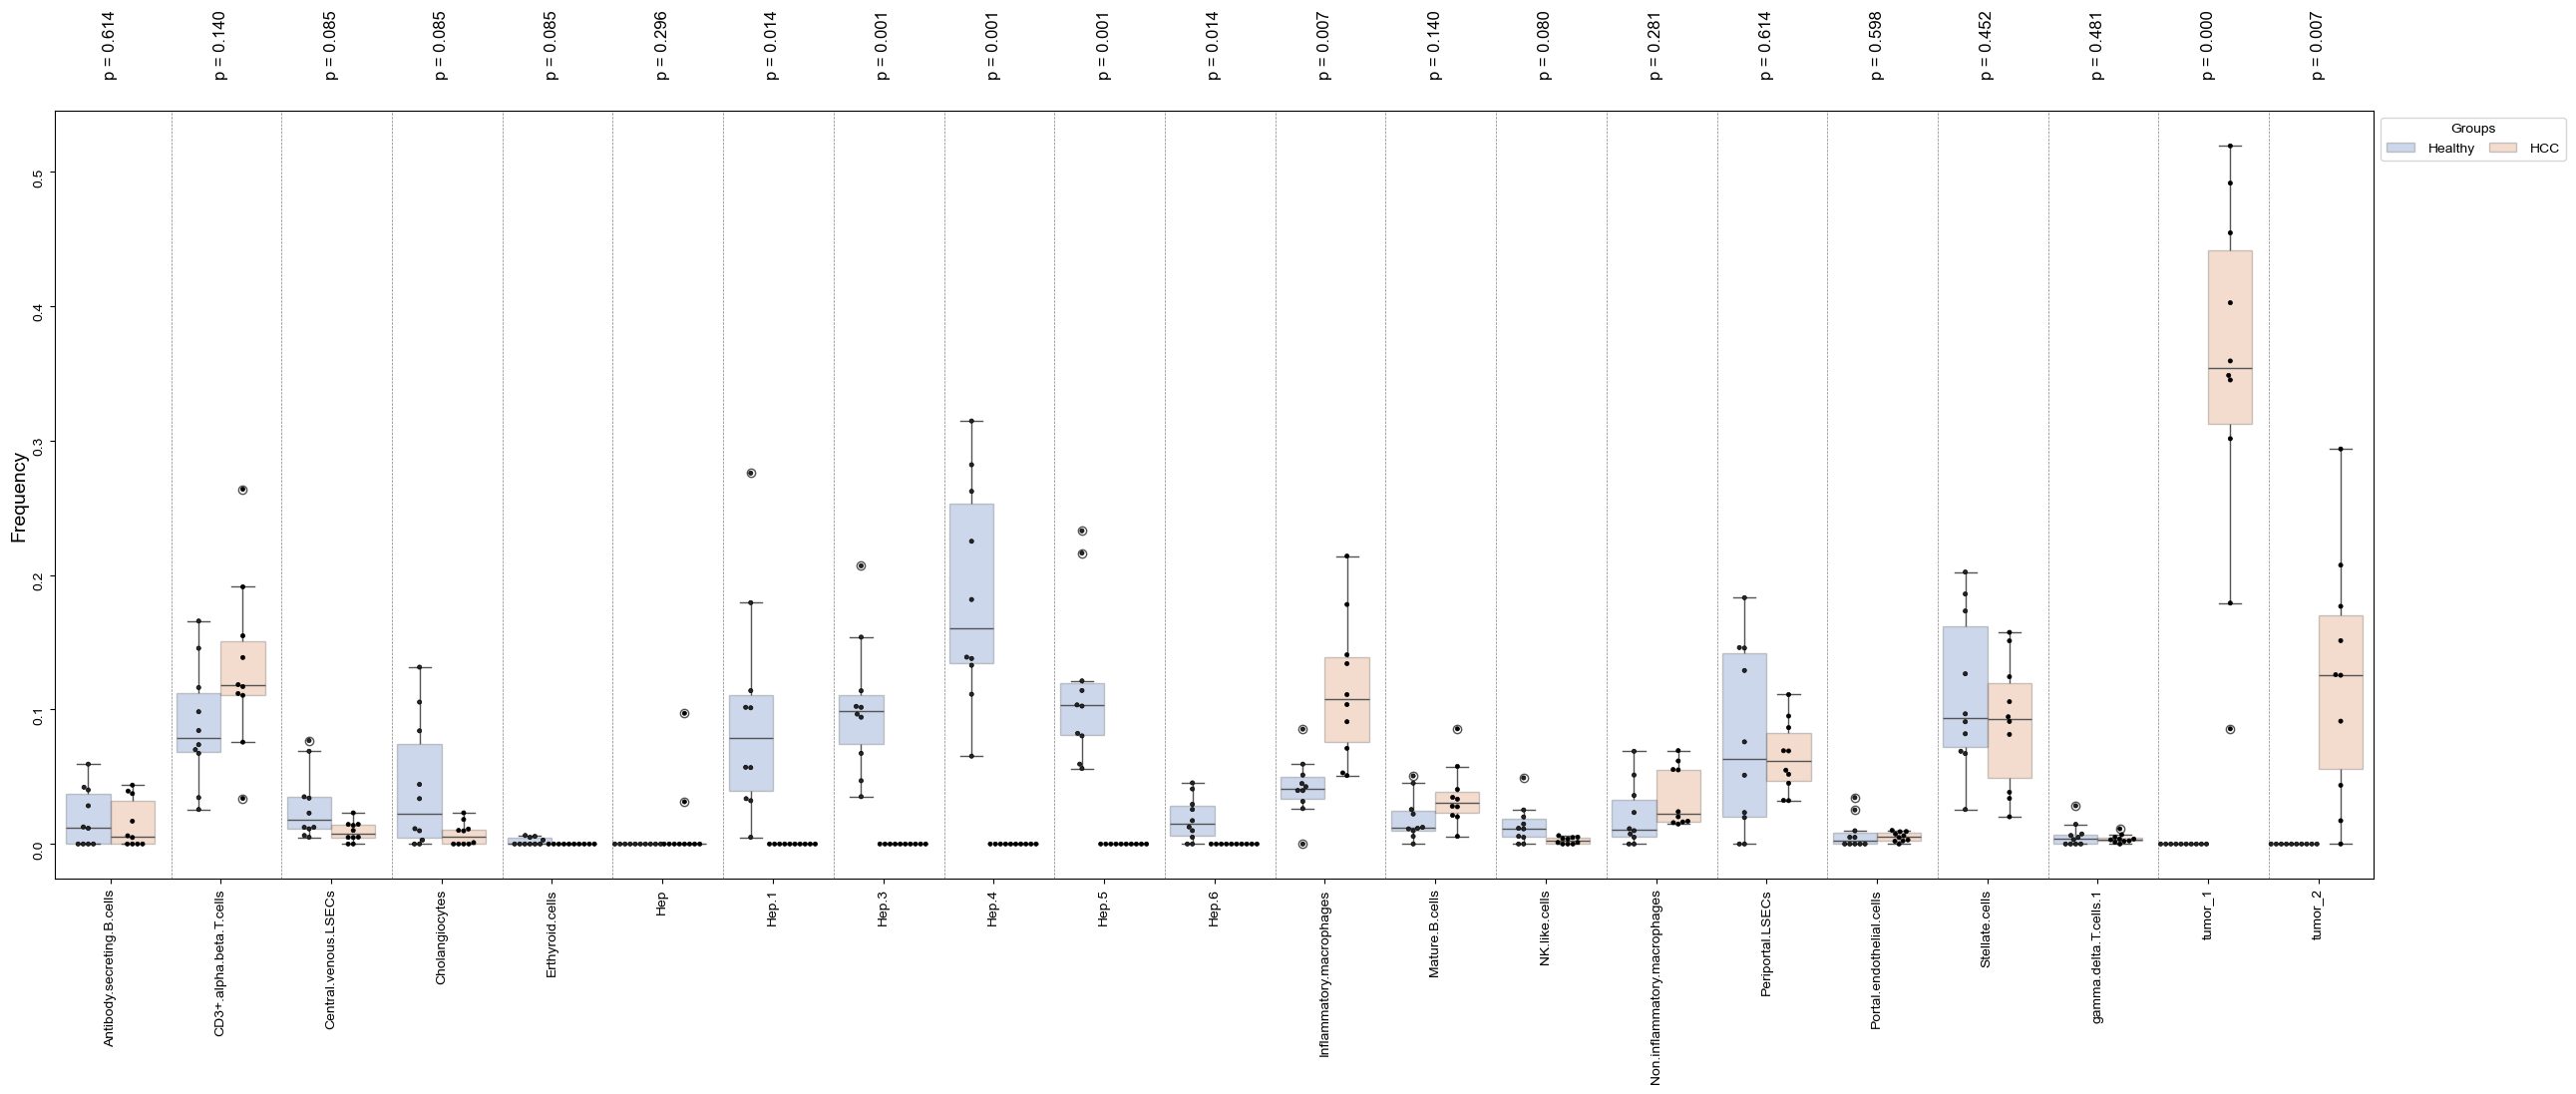

In [27]:
selected_cell_types = sorted(spot_cellfreq_df_melt['CellType'].unique())
selected_p_values = []

# Perform t-tests
print(f"p-value before correction:")
for ct in selected_cell_types: # df_melted['CellType'].unique():
    subset = spot_cellfreq_df_melt[spot_cellfreq_df_melt['CellType'] == ct]
    group1 = subset[subset['Condition'] == 'Healthy']['Frequency']
    group2 = subset[subset['Condition'] == 'HCC']['Frequency']

    t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
    print(f"{ct} has p value = {p_value:.4f}")    
    selected_p_values.append(p_value)

# Filter the dataframe based on selected CellTypes
df_filtered = spot_cellfreq_df_melt[spot_cellfreq_df_melt['CellType'].isin(selected_cell_types)]

# Plot the filtered data
fig, ax = plt.subplots(figsize=(30,10))
sns.boxplot(data=df_filtered, x='CellType', y='Frequency', hue='Condition', palette='muted', boxprops=dict(alpha=.3), ax=ax, dodge=True,order=selected_cell_types)
sns.swarmplot(data=df_filtered, x='CellType', y='Frequency', hue='Condition', palette='dark:black', size=3.0, dodge=True, order=selected_cell_types, ax=ax, edgecolor='auto', linewidth=0.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="Groups", handletextpad=1, columnspacing=1, bbox_to_anchor=(1, 1), ncol=3, frameon=True)

spot_pvals_corrected = stats.false_discovery_control(selected_p_values, method='bh')
spot_pvals_corrected = dict(map(lambda i,j : (i,j) , selected_cell_types, spot_pvals_corrected))

print('-'*42)
print(f"p-values after correction: ")

yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
for i, ct in enumerate(selected_cell_types):
    ax.text(i, yrange, f"p = {spot_pvals_corrected[ct]:.3f}", ha='center', fontsize=12, rotation=90)
    print(f"{ct} in hot spots has p value = {spot_pvals_corrected[ct]:.3f}", flush=True)
    if spot_pvals_corrected[ct] < 0.05 and p_vals_corrected_dict[ct] > 0.05:
        print(f"{ct} in whole tissue has p value = {p_vals_corrected_dict[ct]:.3f}", flush=True)
        print('*'*42)
    
for i in range(len(selected_cell_types) - 1):
    ax.axvline(i + 0.55, color='grey', linestyle='--', linewidth=0.5)
    
ax.set_ylabel("Frequency", fontsize=14)
ax.set_xlabel('')    
plt.xticks(rotation=90)  
plt.yticks(rotation=90) 
plt.show()
plt.close(fig)


### Process Cell Co-Occurrence Dataframe

In [28]:
union_cols = set(global_co_occurrence_subcols).union(set(spot_co_occurrence_subcols))

In [29]:
# Make them have the same set of columns
global_co_occurrence_df = global_co_occurrence_df.reindex(columns=union_cols).fillna(0)
spot_co_occurrence_df = spot_co_occurrence_df.reindex(columns=union_cols).fillna(0)

In [30]:
# Global Cell Co-Occurrence 
# Multi-index to single-index column
new_columns = []
for col in global_co_occurrence_df.columns:
    if isinstance(col, tuple):  # This checks if the column is a MultiIndex
        # Join only if the column name is not 'Mouse' or 'Condition'
        if "sample" not in col and "Condition" not in col:
            new_columns.append('&'.join(map(str, col)).strip())
        else:
            # If 'Mouse' or 'Condition' is in the column, it is not joined with '&'
            new_columns.append(col[0])
    else:
        new_columns.append(col)

global_co_occurrence_df_single = global_co_occurrence_df.copy()
global_co_occurrence_df_single.columns = new_columns
global_co_occurrence_df_single = global_co_occurrence_df_single[[col for col in global_co_occurrence_df_single.columns if 'NotDet' not in col]]

# Melt the DataFrame
global_co_occurrence_melted = global_co_occurrence_df_single.melt(id_vars=['sample', 'Condition'], var_name='Cell Combination', value_name='Frequency')
global_co_occurrence_melted

,sample,Condition,Cell Combination,Frequency
0,N1,Healthy,Periportal.LSECs&tumor_1,0.0
1,N7,Healthy,Periportal.LSECs&tumor_1,0.0
2,N9,Healthy,Periportal.LSECs&tumor_1,0.0
3,N6,Healthy,Periportal.LSECs&tumor_1,0.0
4,N8,Healthy,Periportal.LSECs&tumor_1,0.0
...,...,...,...,...
1555,C7,HCC,CD3+.alpha.beta.T.cells&Hep.6,0.0
1556,C9,HCC,CD3+.alpha.beta.T.cells&Hep.6,0.0
1557,C2,HCC,CD3+.alpha.beta.T.cells&Hep.6,0.0
1558,C3,HCC,CD3+.alpha.beta.T.cells&Hep.6,0.0


p-value before correction:
Antibody.secreting.B.cells&CD3+.alpha.beta.T.cells has p value = 0.962
Antibody.secreting.B.cells&Inflammatory.macrophages has p value = 0.734
Antibody.secreting.B.cells&Mature.B.cells has p value = 0.560
Antibody.secreting.B.cells&Periportal.LSECs has p value = 0.111
Antibody.secreting.B.cells&Stellate.cells has p value = 0.406
CD3+.alpha.beta.T.cells&Central.venous.LSECs has p value = 0.001
CD3+.alpha.beta.T.cells&Cholangiocytes has p value = 0.000
CD3+.alpha.beta.T.cells&Hep.1 has p value = 0.000
CD3+.alpha.beta.T.cells&Hep.3 has p value = 0.000
CD3+.alpha.beta.T.cells&Hep.4 has p value = 0.000
CD3+.alpha.beta.T.cells&Hep.5 has p value = 0.000
CD3+.alpha.beta.T.cells&Hep.6 has p value = 0.000
CD3+.alpha.beta.T.cells&Inflammatory.macrophages has p value = 0.204
CD3+.alpha.beta.T.cells&Mature.B.cells has p value = 0.420
CD3+.alpha.beta.T.cells&NK.like.cells has p value = 0.004
CD3+.alpha.beta.T.cells&Non.inflammatory.macrophages has p value = 0.945
CD3+.alph

/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_73139/917667374.py:22: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.swarmplot(data=df_filtered, x='Cell Combination', y='Frequency', hue='Condition', palette='dark:black', size=1.0, dodge=True,order=selected_cell_types, ax=ax, edgecolor='gray', linewidth=0.5)


------------------------------------------
p-values after correction:
Antibody.secreting.B.cells&CD3+.alpha.beta.T.cells has p value = 0.962
Antibody.secreting.B.cells&Inflammatory.macrophages has p value = 0.773
Antibody.secreting.B.cells&Mature.B.cells has p value = 0.607
Antibody.secreting.B.cells&Periportal.LSECs has p value = 0.139
Antibody.secreting.B.cells&Stellate.cells has p value = 0.452
CD3+.alpha.beta.T.cells&Central.venous.LSECs has p value = 0.001
CD3+.alpha.beta.T.cells&Cholangiocytes has p value = 0.000
CD3+.alpha.beta.T.cells&Hep.1 has p value = 0.000
CD3+.alpha.beta.T.cells&Hep.3 has p value = 0.000
CD3+.alpha.beta.T.cells&Hep.4 has p value = 0.000
CD3+.alpha.beta.T.cells&Hep.5 has p value = 0.000
CD3+.alpha.beta.T.cells&Hep.6 has p value = 0.000
CD3+.alpha.beta.T.cells&Inflammatory.macrophages has p value = 0.241
CD3+.alpha.beta.T.cells&Mature.B.cells has p value = 0.461
CD3+.alpha.beta.T.cells&NK.like.cells has p value = 0.005
CD3+.alpha.beta.T.cells&Non.inflammator

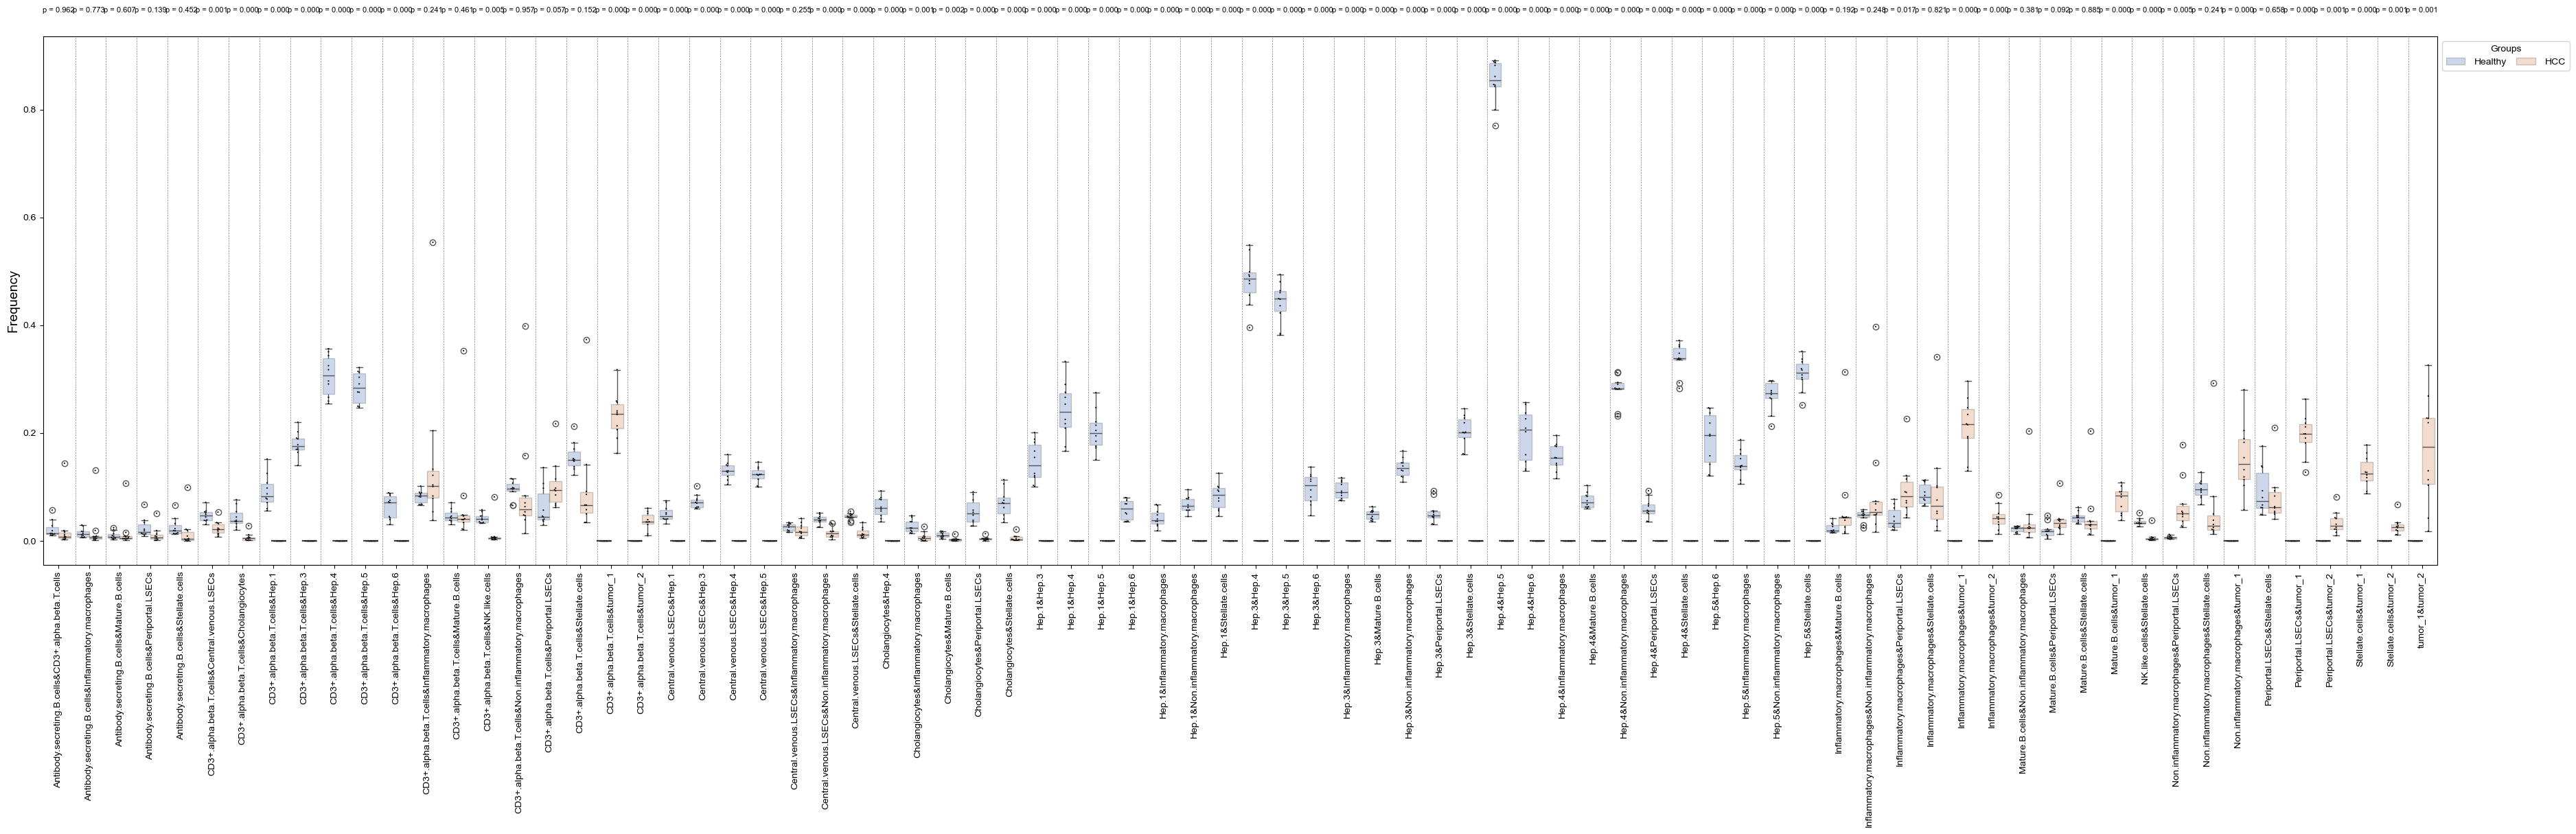

In [31]:
# Global Cell Co-Occurrence 
selected_cell_types = sorted(global_co_occurrence_melted['Cell Combination'].unique())
selected_p_values = []

# Perform t-tests
print(f"p-value before correction:")
for ct in selected_cell_types:
    subset = global_co_occurrence_melted[global_co_occurrence_melted['Cell Combination'] == ct]
    group1 = subset[subset['Condition'] == 'Healthy']['Frequency']
    group2 = subset[subset['Condition'] == 'HCC']['Frequency']

    t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
    print(f"{ct} has p value = {p_value:.3f}")
    selected_p_values.append(p_value)

# Filter the dataframe based on selected Cell Combinations
df_filtered = global_co_occurrence_melted[global_co_occurrence_melted['Cell Combination'].isin(selected_cell_types)]

# Plot the filtered data
fig, ax = plt.subplots(figsize=(45,10))
sns.boxplot(data=df_filtered, x='Cell Combination', y='Frequency', hue='Condition', palette='muted', boxprops=dict(alpha=.3), ax=ax, dodge=True,order=selected_cell_types)
sns.swarmplot(data=df_filtered, x='Cell Combination', y='Frequency', hue='Condition', palette='dark:black', size=1.0, dodge=True,order=selected_cell_types, ax=ax, edgecolor='gray', linewidth=0.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="Groups", handletextpad=1, columnspacing=1, bbox_to_anchor=(1, 1), ncol=3, frameon=True)

pvals_corrected = stats.false_discovery_control(selected_p_values, method='bh')

print('-'*42)
print(f"p-values after correction:")

p_vals_corrected_dict = {}
yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
for i, ct in enumerate(selected_cell_types):
    ax.text(i, yrange, f"p = {pvals_corrected[i]:.3f}", ha='center', fontsize=8, rotation=0)
    print(f"{ct} has p value = {pvals_corrected[i]:.3f}", flush=True)
    p_vals_corrected_dict[ct] = pvals_corrected[i]
    
for i in range(len(selected_cell_types) - 1):
    ax.axvline(i + 0.55, color='grey', linestyle='--', linewidth=0.5)
    
ax.set_ylabel("Frequency", fontsize=14)
ax.set_xlabel('')   
plt.xticks(rotation=90)  
plt.show()

In [32]:
# Spot Cell Co-Occurrence
# Multi-index to single-index column
new_columns = []
for col in spot_co_occurrence_df.columns:
    if isinstance(col, tuple):  # This checks if the column is a MultiIndex
        # Join only if the column name is not 'Mouse' or 'Condition'
        if "sample" not in col and "Condition" not in col:
            new_columns.append('&'.join(map(str, col)).strip())
        else:
            # If 'Mouse' or 'Condition' is in the column, it is not joined with '&'
            new_columns.append(col[0])
    else:
        new_columns.append(col)

spot_co_occurrence_df_single = spot_co_occurrence_df.copy()
spot_co_occurrence_df_single.columns = new_columns
spot_co_occurrence_df_single = spot_co_occurrence_df_single[[col for col in spot_co_occurrence_df_single.columns if 'noid' not in col]]

# Melt the DataFrame
spot_co_occurrence_melted = spot_co_occurrence_df_single.melt(id_vars=['sample', 'Condition'], var_name='Cell Combination', value_name='Frequency')
spot_co_occurrence_melted

,sample,Condition,Cell Combination,Frequency
0,N1,Healthy,Periportal.LSECs&tumor_1,0.0
1,N7,Healthy,Periportal.LSECs&tumor_1,0.0
2,N9,Healthy,Periportal.LSECs&tumor_1,0.0
3,N6,Healthy,Periportal.LSECs&tumor_1,0.0
4,N8,Healthy,Periportal.LSECs&tumor_1,0.0
...,...,...,...,...
1555,C7,HCC,CD3+.alpha.beta.T.cells&Hep.6,0.0
1556,C9,HCC,CD3+.alpha.beta.T.cells&Hep.6,0.0
1557,C2,HCC,CD3+.alpha.beta.T.cells&Hep.6,0.0
1558,C3,HCC,CD3+.alpha.beta.T.cells&Hep.6,0.0


p-value before correction: 
Antibody.secreting.B.cells&CD3+.alpha.beta.T.cells has p value = 0.293
Antibody.secreting.B.cells&Inflammatory.macrophages has p value = 0.400
Antibody.secreting.B.cells&Mature.B.cells has p value = 0.456
Antibody.secreting.B.cells&Periportal.LSECs has p value = 0.092
Antibody.secreting.B.cells&Stellate.cells has p value = 0.211
CD3+.alpha.beta.T.cells&Central.venous.LSECs has p value = 0.069
CD3+.alpha.beta.T.cells&Cholangiocytes has p value = 0.037
CD3+.alpha.beta.T.cells&Hep.1 has p value = 0.001
CD3+.alpha.beta.T.cells&Hep.3 has p value = 0.000
CD3+.alpha.beta.T.cells&Hep.4 has p value = 0.000
CD3+.alpha.beta.T.cells&Hep.5 has p value = 0.000
CD3+.alpha.beta.T.cells&Hep.6 has p value = 0.023
CD3+.alpha.beta.T.cells&Inflammatory.macrophages has p value = 0.060
CD3+.alpha.beta.T.cells&Mature.B.cells has p value = 0.266
CD3+.alpha.beta.T.cells&NK.like.cells has p value = 0.016
CD3+.alpha.beta.T.cells&Non.inflammatory.macrophages has p value = 0.008
CD3+.alp

/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_73139/754806585.py:22: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.swarmplot(data=df_filtered, x='Cell Combination', y='Frequency', hue='Condition', palette='dark:black', size=2.0, dodge=True,order=selected_cell_types, ax=ax, edgecolor='gray', linewidth=0.5)
/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


------------------------------------------
p-values after correction:
Antibody.secreting.B.cells&CD3+.alpha.beta.T.cells in hot spots has p value = 0.336
Antibody.secreting.B.cells&Inflammatory.macrophages in hot spots has p value = 0.446
Antibody.secreting.B.cells&Mature.B.cells in hot spots has p value = 0.501
Antibody.secreting.B.cells&Periportal.LSECs in hot spots has p value = 0.122
Antibody.secreting.B.cells&Stellate.cells in hot spots has p value = 0.257
CD3+.alpha.beta.T.cells&Central.venous.LSECs in hot spots has p value = 0.094
CD3+.alpha.beta.T.cells&Cholangiocytes in hot spots has p value = 0.053
CD3+.alpha.beta.T.cells&Hep.1 in hot spots has p value = 0.002
CD3+.alpha.beta.T.cells&Hep.3 in hot spots has p value = 0.000
CD3+.alpha.beta.T.cells&Hep.4 in hot spots has p value = 0.000
CD3+.alpha.beta.T.cells&Hep.5 in hot spots has p value = 0.000
CD3+.alpha.beta.T.cells&Hep.6 in hot spots has p value = 0.039
CD3+.alpha.beta.T.cells&Inflammatory.macrophages in hot spots has p v

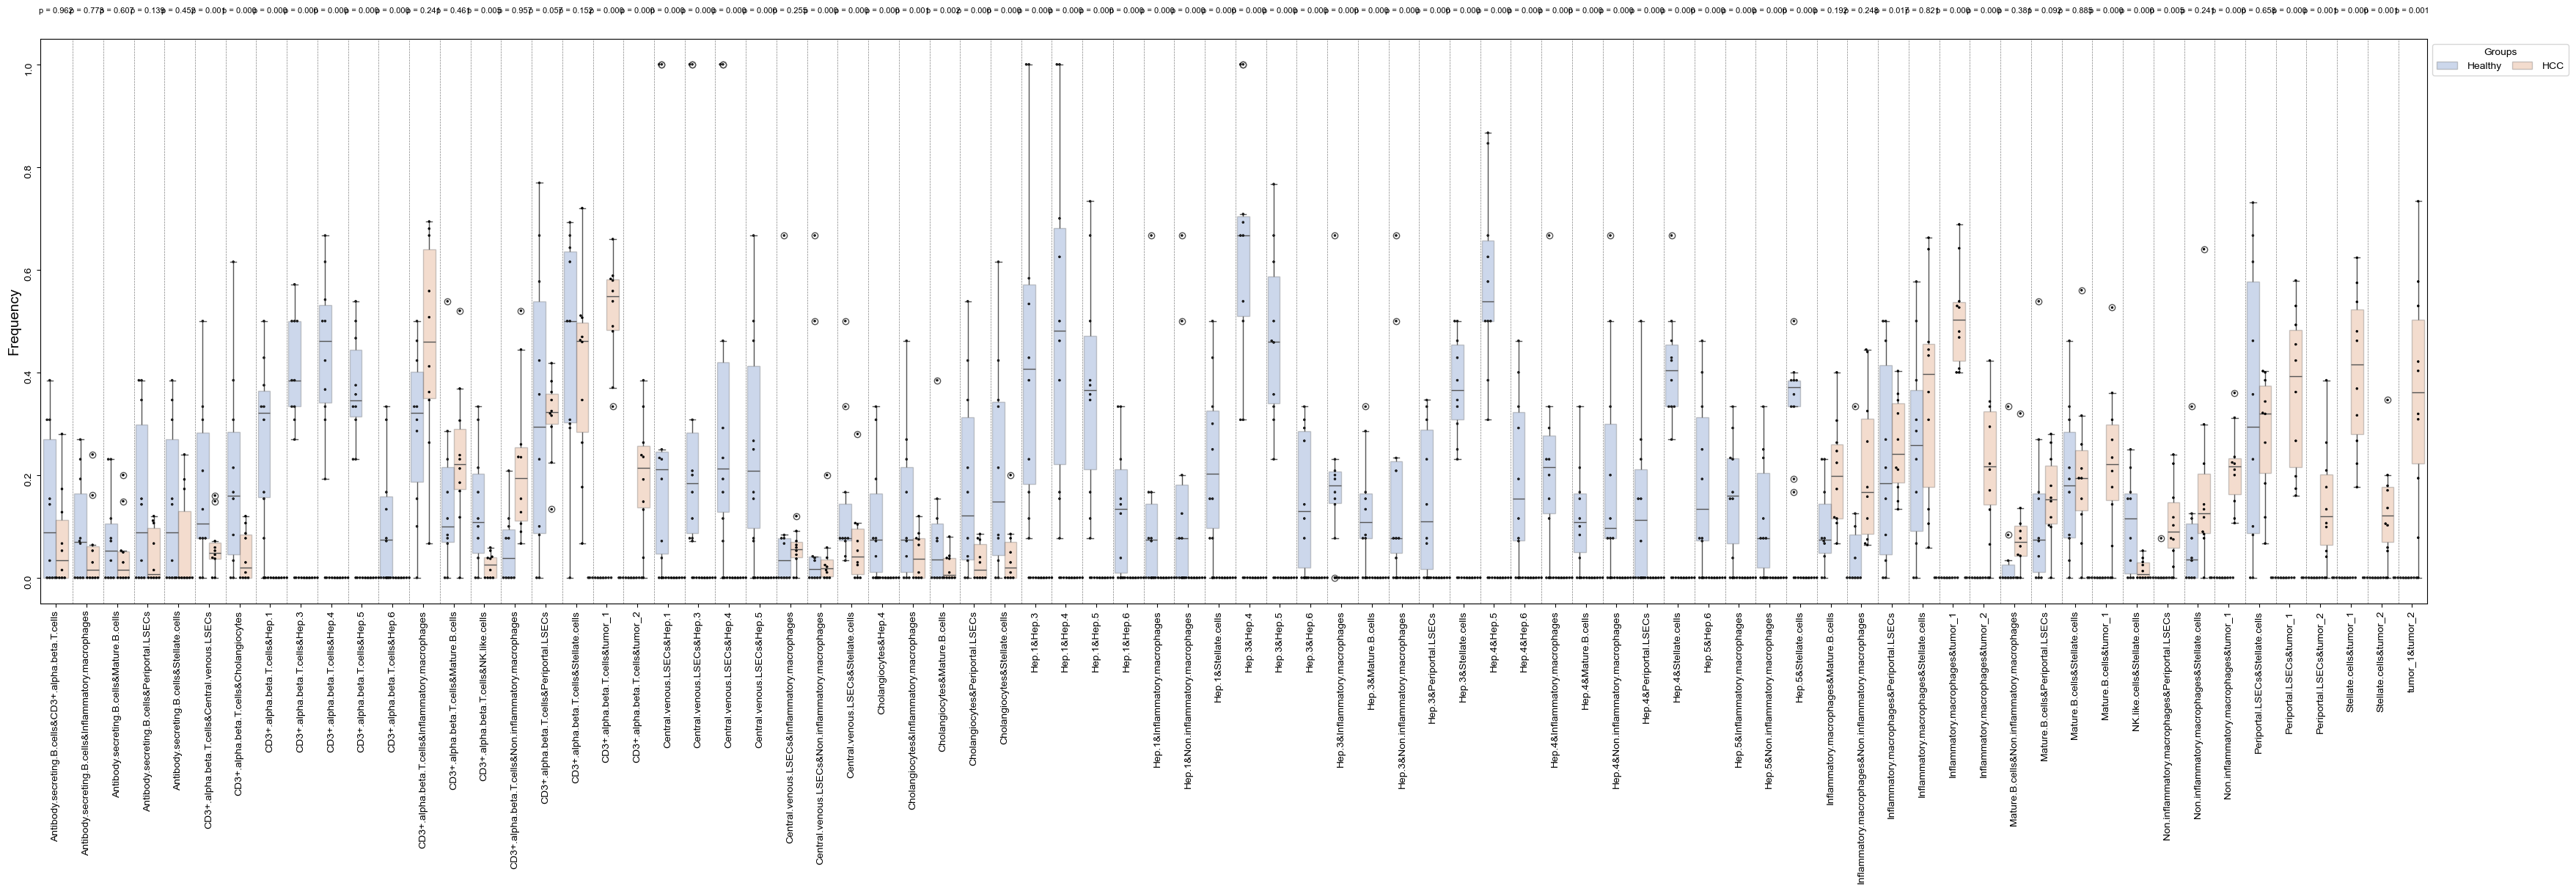

In [33]:
# Spot Cell Co-Occurrence    
selected_cell_types = sorted(spot_co_occurrence_melted['Cell Combination'].unique())
selected_p_values = []

# Perform t-tests
print(f"p-value before correction: ")
for ct in selected_cell_types: # df_melted['CellType'].unique():
    subset = spot_co_occurrence_melted[spot_co_occurrence_melted['Cell Combination'] == ct]
    group1 = subset[subset['Condition'] == 'Healthy']['Frequency']
    group2 = subset[subset['Condition'] == 'HCC']['Frequency']

    t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
    print(f"{ct} has p value = {p_value:.3f}")
    selected_p_values.append(p_value)

# Filter the dataframe based on selected CellTypes
df_filtered = spot_co_occurrence_melted[spot_co_occurrence_melted['Cell Combination'].isin(selected_cell_types)]

# Plot the filtered data
fig, ax = plt.subplots(figsize=(42,10))
sns.boxplot(data=df_filtered, x='Cell Combination', y='Frequency', hue='Condition', palette='muted', boxprops=dict(alpha=.3), ax=ax, dodge=True,order=selected_cell_types)
sns.swarmplot(data=df_filtered, x='Cell Combination', y='Frequency', hue='Condition', palette='dark:black', size=2.0, dodge=True,order=selected_cell_types, ax=ax, edgecolor='gray', linewidth=0.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="Groups", handletextpad=1, columnspacing=1, bbox_to_anchor=(1, 1), ncol=3, frameon=True)

hot_pvals_corrected = stats.false_discovery_control(selected_p_values, method='bh')

print('-'*42)
print(f"p-values after correction:")

highlighted_comb = []
yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
for i, ct in enumerate(selected_cell_types):
    ax.text(i, yrange, f"p = {pvals_corrected[i]:.3f}", ha='center', fontsize=8, rotation=0)
    print(f"{ct} in hot spots has p value = {hot_pvals_corrected[i]:.3f}", flush=True)
    if hot_pvals_corrected[i] < 0.05 and p_vals_corrected_dict[ct] >= 0.05:
        highlighted_comb.append(tuple(map(str.strip, ct.split('&'))))
        print(f"{ct} in whole tissue has p value = {p_vals_corrected_dict[ct]:.3f}", flush=True)
        print('*'*42)
    
for i in range(len(selected_cell_types) - 1):
    ax.axvline(i + 0.55, color='grey', linestyle='--', linewidth=0.5)
    
ax.set_ylabel("Frequency", fontsize=14)
ax.set_xlabel('')   
plt.xticks(rotation=90)  
plt.yticks(rotation=90)  
plt.show()

### Cell Co-Occurrence Circle Plot

In [34]:
circoplot_df1 = global_co_occurrence_df.sort_index(axis=1, level=[0,1]).drop(columns=['sample'])
circoplot_df1 = circoplot_df1[[col for col in circoplot_df1.columns if 'NotDet' not in col]]
# Group by 'Condition' and calculate the mean of the other columns
circoplot_df1 = circoplot_df1.groupby('Condition').mean().reset_index()
circoplot_df1 = circoplot_df1.set_index('Condition')
circoplot_df1

Antibody.secreting.B.cells                                          \
             CD3+.alpha.beta.T.cells Inflammatory.macrophages Mature.B.cells   
Condition                                                                      
HCC                         0.022196                 0.018992       0.016074   
Healthy                     0.021499                 0.014525       0.009815   

                                          CD3+.alpha.beta.T.cells  \
          Periportal.LSECs Stellate.cells    Central.venous.LSECs   
Condition                                                           
HCC               0.011441       0.016042                0.023526   
Healthy           0.023953       0.025427                0.046878   

                                                        ...  NK.like.cells  \
          Cholangiocytes     Hep.1     Hep.3     Hep.4  ... Stellate.cells   
Condition                                               ...                  
HCC             0.006582  0.000000  0.000000  0.000000  ...       0.006711   
Healthy         0.043016  0.091162  0.179436  0.305974  ...       0.034734   

          Non.inflammatory.macrophages                           \
                      Periportal.LSECs Stellate.cells   tumor_1   
Condition                                                         
HCC                           0.065835       0.058693  0.153495   
Healthy                       0.006585       0.096116  0.000000   

          Periportal.LSECs                     Stellate.cells            \
            Stellate.cells   tumor_1   tumor_2        tumor_1   tumor_2   
Condition                                                                 
HCC               0.080329  0.195998  0.034058       0.127627  0.027149   
Healthy           0.091030  0.000000  0.000000       0.000000  0.000000   

            tumor_1  
            tumor_2  
Condition            
HCC        0.167421  
Healthy    0.000000  

[2 rows x 78 columns]

In [35]:
circoplot_df2 = global_cellfreq_df.drop(columns=['NotDet'])
# Group by 'Condition' and calculate the mean of the other columns
circoplot_df2 = circoplot_df2.groupby('Condition').mean().reset_index()
circoplot_df2 = circoplot_df2.set_index('Condition')
circoplot_df2

cellType,Antibody.secreting.B.cells,CD3+.alpha.beta.T.cells,Central.venous.LSECs,Cholangiocytes,Erthyroid.cells,Hep,Hep.1,Hep.3,Hep.4,Hep.5,...,Inflammatory.macrophages,Mature.B.cells,NK.like.cells,Non.inflammatory.macrophages,Periportal.LSECs,Portal.endothelial.cells,Stellate.cells,gamma.delta.T.cells.1,tumor_1,tumor_2
Condition,,,,,,,,,,,,,,,,,,,,,
HCC,0.004335,0.052099,0.004248,0.001246,0.000355,0.004334,0.000000,0.000000,0.000000,0.000000,...,0.041426,0.012241,0.001372,0.021900,0.029793,0.002345,0.024236,0.001431,0.743387,0.055246
Healthy,0.005318,0.042423,0.012634,0.018712,0.003344,0.000000,0.041616,0.068025,0.368931,0.263174,...,0.019289,0.008970,0.008195,0.028868,0.024384,0.001588,0.055661,0.009370,0.000000,0.000000


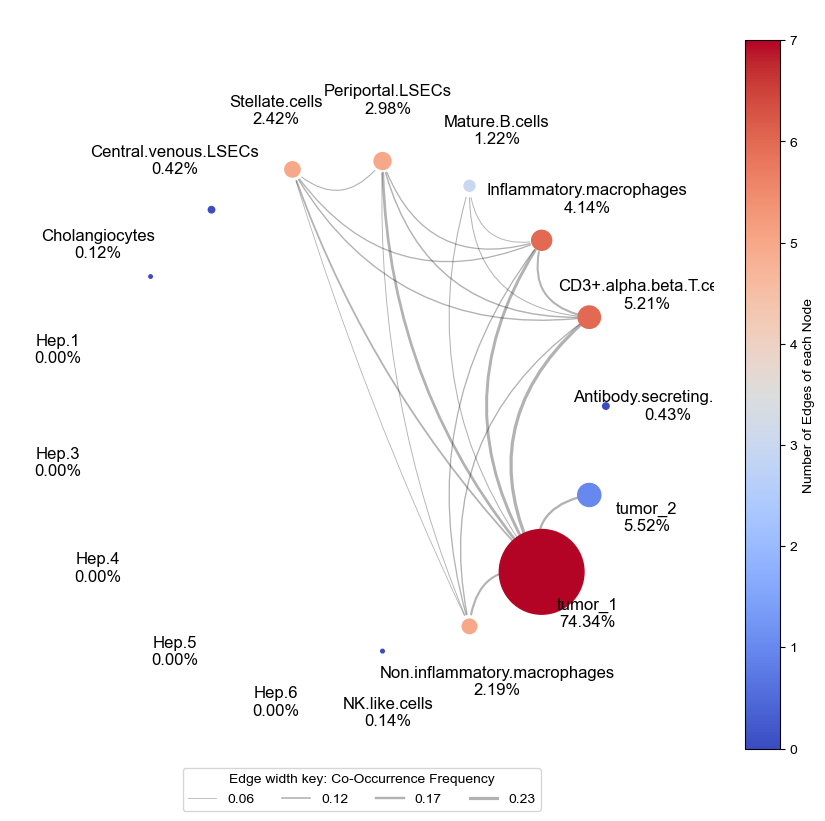

In [37]:
patient_group = 'HCC'
eco.create_circos_plot(circoplot_df1.loc[[patient_group]], 
                       cell_type_colors_hex=None,
                       cell_abundance=circoplot_df2.loc[[patient_group]],
                       threshold=0.05, 
                       edge_weights_scaler=10,
                       highlighted_edges=None,
                       node_weights_scaler=5000,
                       figure_size=(8,8),
                       save_path='/Users/Emrys/Downloads/'+patient_group+'_wholetissue_circoplot.svg')

In [38]:
circoplot_df1 = spot_co_occurrence_df.sort_index(axis=1, level=[0,1]).drop(columns=['sample'])
circoplot_df1 = circoplot_df1[[col for col in circoplot_df1.columns if 'NotDet' not in col]]
# Group by 'Condition' and calculate the mean of the other columns
circoplot_df1 = circoplot_df1.groupby('Condition').mean().reset_index()
circoplot_df1 = circoplot_df1.set_index('Condition')
circoplot_df1

Antibody.secreting.B.cells                                          \
             CD3+.alpha.beta.T.cells Inflammatory.macrophages Mature.B.cells   
Condition                                                                      
HCC                         0.071472                 0.054681       0.048080   
Healthy                     0.133004                 0.090733       0.075861   

                                          CD3+.alpha.beta.T.cells  \
          Periportal.LSECs Stellate.cells    Central.venous.LSECs   
Condition                                                           
HCC               0.041909       0.060433                0.061259   
Healthy           0.144542       0.136850                0.171346   

                                                        ...  NK.like.cells  \
          Cholangiocytes     Hep.1     Hep.3     Hep.4  ... Stellate.cells   
Condition                                               ...                  
HCC             0.042978  0.000000  0.000000  0.000000  ...       0.015938   
Healthy         0.195916  0.267537  0.408425  0.444679  ...       0.104890   

          Non.inflammatory.macrophages                           \
                      Periportal.LSECs Stellate.cells   tumor_1   
Condition                                                         
HCC                           0.106321       0.180634  0.213524   
Healthy                       0.007692       0.072244  0.000000   

          Periportal.LSECs                     Stellate.cells            \
            Stellate.cells   tumor_1   tumor_2        tumor_1   tumor_2   
Condition                                                                 
HCC               0.280178  0.363789  0.146445        0.40268  0.134935   
Healthy           0.324560  0.000000  0.000000        0.00000  0.000000   

           tumor_1  
           tumor_2  
Condition           
HCC        0.35633  
Healthy    0.00000  

[2 rows x 78 columns]

In [40]:
circoplot_df2 = spot_cellfreq_df.drop(columns=['sample'])
# Group by 'Condition' and calculate the mean of the other columns
circoplot_df2 = circoplot_df2.groupby('Condition').mean().reset_index()
circoplot_df2 = circoplot_df2.set_index('Condition')
circoplot_df2

,Antibody.secreting.B.cells,CD3+.alpha.beta.T.cells,Central.venous.LSECs,Cholangiocytes,Erthyroid.cells,Hep,Hep.1,Hep.3,Hep.4,Hep.5,...,Inflammatory.macrophages,Mature.B.cells,NK.like.cells,Non.inflammatory.macrophages,Periportal.LSECs,Portal.endothelial.cells,Stellate.cells,gamma.delta.T.cells.1,tumor_1,tumor_2
Condition,,,,,,,,,,,,,,,,,,,,,
HCC,0.014845,0.131641,0.009099,0.007342,0.00000,0.01286,0.000000,0.000000,0.000000,0.000000,...,0.114776,0.035472,0.002622,0.034992,0.064790,0.005422,0.089846,0.003930,0.348701,0.12329
Healthy,0.019455,0.088204,0.028539,0.042334,0.00199,0.00000,0.095709,0.101915,0.185243,0.116906,...,0.042112,0.019463,0.014303,0.021344,0.077415,0.007962,0.111953,0.006503,0.000000,0.00000


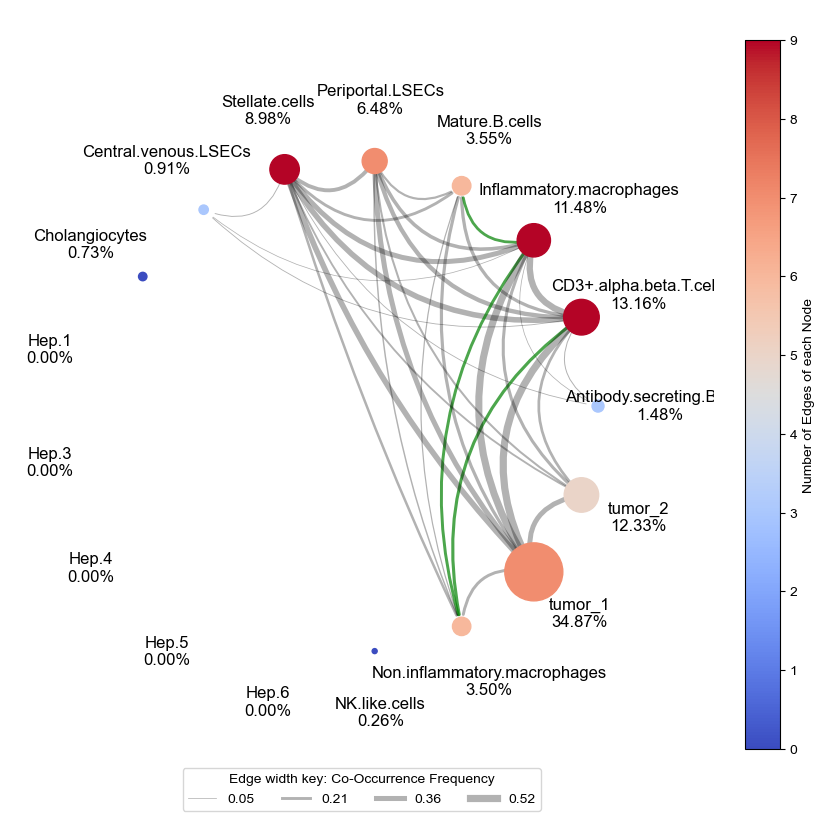

In [42]:
patient_group = 'HCC'
eco.create_circos_plot(circoplot_df1.loc[[patient_group]], 
                       cell_type_colors_hex=None,
                       cell_abundance=circoplot_df2.loc[[patient_group]],
                       threshold=0.05, 
                       edge_weights_scaler=10,
                       highlighted_edges=highlighted_comb,
                       node_weights_scaler=5000,
                       figure_size=(8,8),
                       save_path='/Users/Emrys/Downloads/'+patient_group+'_hotspots_circoplot.svg')